<a href="https://colab.research.google.com/github/Haryogul/4212201055-AAS-CN/blob/main/AAS_MACHINE_VISION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [ ]:
import pandas as pd
import torch
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Load dataset**

In [ ]:
train_df = pd.read_csv('/content/emnist-balanced-test.csv', header=None)
test_df = pd.read_csv('/content/emnist-balanced-train.csv', header=None)

**Data Preprocess**

In [ ]:
def preprocess_image(data):
    data = np.clip(data, 0, 255).astype(np.uint8).reshape(28, 28)
    return Image.fromarray(data).convert("RGB")

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        img_data = self.dataframe.iloc[idx, 1:].values
        image = preprocess_image(img_data)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Define model**

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.base_model = models.alexnet(pretrained=True)
        self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

num_classes = len(np.unique(train_df.iloc[:, 0].values))
model = TransferLearningModel(num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 124MB/s]


**Freeze Feature Extractor Layers**

In [ ]:
for param in model.base_model.features.parameters():
    param.requires_grad = False

**Loss and Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Training**

In [ ]:
# Assuming the training dataset is defined as train_dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define validation dataset and loader
val_dataset = CustomDataset(test_df, transform=transform)  # You can use a different dataset for validation if needed
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy for training data
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation after each epoch
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Loss: 0.6786, Train Accuracy: 77.58%
Epoch 1/10, Validation Accuracy: 82.62%
Epoch 2/10, Loss: 0.5537, Train Accuracy: 80.79%
Epoch 2/10, Validation Accuracy: 83.96%
Epoch 3/10, Loss: 0.5036, Train Accuracy: 82.11%
Epoch 3/10, Validation Accuracy: 83.39%
Epoch 4/10, Loss: 0.4819, Train Accuracy: 83.10%
Epoch 4/10, Validation Accuracy: 84.26%
Epoch 5/10, Loss: 0.4538, Train Accuracy: 84.05%
Epoch 5/10, Validation Accuracy: 85.23%
Epoch 6/10, Loss: 0.4220, Train Accuracy: 84.77%
Epoch 6/10, Validation Accuracy: 85.40%
Epoch 7/10, Loss: 0.4168, Train Accuracy: 85.01%
Epoch 7/10, Validation Accuracy: 84.16%
Epoch 8/10, Loss: 0.3979, Train Accuracy: 85.42%
Epoch 8/10, Validation Accuracy: 85.14%
Epoch 9/10, Loss: 0.3855, Train Accuracy: 85.86%
Epoch 9/10, Validation Accuracy: 85.24%
Epoch 10/10, Loss: 0.4008, Train Accuracy: 85.41%
Epoch 10/10, Validation Accuracy: 84.97%


**Metrics**

In [ ]:
# Inisialisasi list untuk menyimpan nilai sebenarnya dan prediksi
y_true = []
y_pred = []

# Model dalam mode evaluasi
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Tambahkan hasil ke daftar
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Hitung metrik evaluasi
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Cetak hasil evaluasi
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")


Confusion Matrix:
[[2001    0    0 ...    1    0    0]
 [   0 2042    2 ...    0    0    0]
 [   0    0 2140 ...    4    0    0]
 ...
 [   1    0    0 ...  626    0    0]
 [   1    3    0 ...    0 2179    4]
 [   1    1    0 ...    0    9 2043]]
Accuracy: 0.8497
Precision: 0.8653
F1-Score: 0.8451


**Visualization**

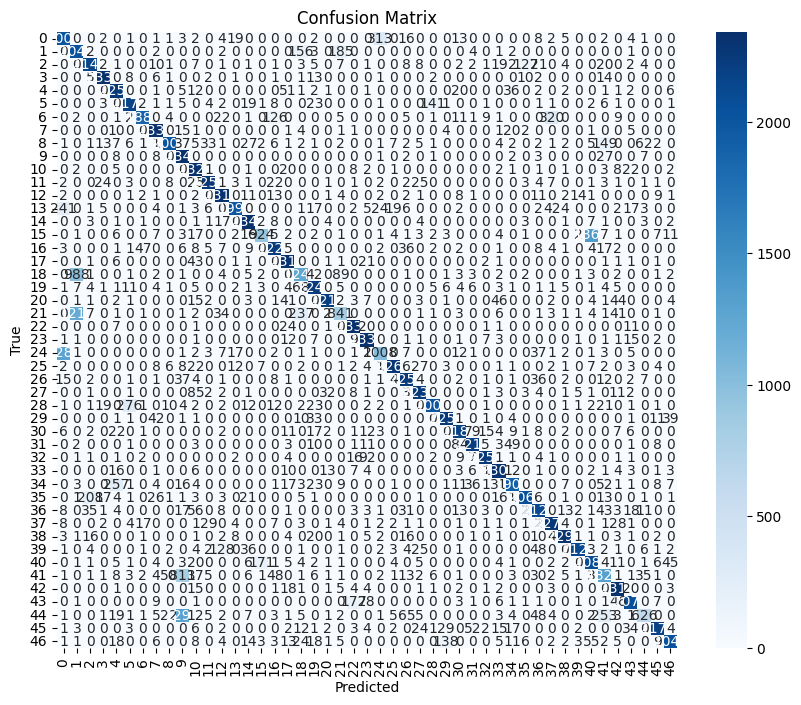

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan cm adalah confusion matrix yang sudah dihitung
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**LOOCV Implementation**

In [ ]:
# Inisialisasi model dan optimizer sekali saja
model = TransferLearningModel(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Freeze model features hanya sekali
for param in model.base_model.features.parameters():
    param.requires_grad = False

# Mulai LOOCV
print("Starting LOOCV...")
for train_idx, test_idx in tqdm(loo.split(data_array)):
    # Data untuk train dan test
    train_samples = data_array[train_idx]
    test_sample = data_array[test_idx]

    # Dataset dan DataLoader untuk batch yang lebih besar
    train_dataset = CustomDataset(pd.DataFrame(train_samples), transform=transform)
    test_dataset = CustomDataset(pd.DataFrame(test_sample), transform=transform)

    # Hanya buat DataLoader sekali per iterasi
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  # Gunakan batch size yang lebih besar untuk inference

    # Train on current fold
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on current test sample in batches
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:  # Menggunakan batch inference
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.append(torch.argmax(outputs, dim=1).cpu().item())
            all_labels.append(labels.cpu().item())


Starting LOOCV...


55it [30:15, 33.13s/it]

**Final metrics after LOOCV**

In [ ]:
cm_loocv = confusion_matrix(all_labels, all_preds)
acc_loocv = accuracy_score(all_labels, all_preds)
precision_loocv = precision_score(all_labels, all_preds, average='macro', zero_division=0)
f1_loocv = f1_score(all_labels, all_preds, average='macro')

print("\nLOOCV Evaluation Results:")
print(f"Confusion Matrix:\n{cm_loocv}")
print(f"Accuracy: {acc_loocv:.4f}")
print(f"Precision: {precision_loocv:.4f}")
print(f"F1-Score: {f1_loocv:.4f}")


LOOCV Evaluation Results:
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.8023
Precision: 0.7610
F1-Score: 0.7429
